In [2]:
import numpy as np 
import pandas as pd
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import data_utils as du
import cv_features as cvf
import viz_utils as viz
import model as mdl
import search as sch
import pipeline as pl
import f2f

from sklearn import svm 
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

## Explore Datasets: Vehicle vs Non-Vehicle

Path: data/vehicles/, Num Images: 8792
Path: data/non-vehicles/, Num Images: 8968
Vehicle Image Dimensons: (64, 64, 3)
Non-Vehicle Image Dimensions: (64, 64, 3)
Vehicle Data Source Counts:
{'KITTI_extracted': 5966, 'GTI_MiddleClose': 419, 'GTI_Far': 834, 'GTI_Right': 664, 'GTI_Left': 909}
Non-Vehicle Data Source Counts:
{'GTI': 3900, 'Extras': 5068}


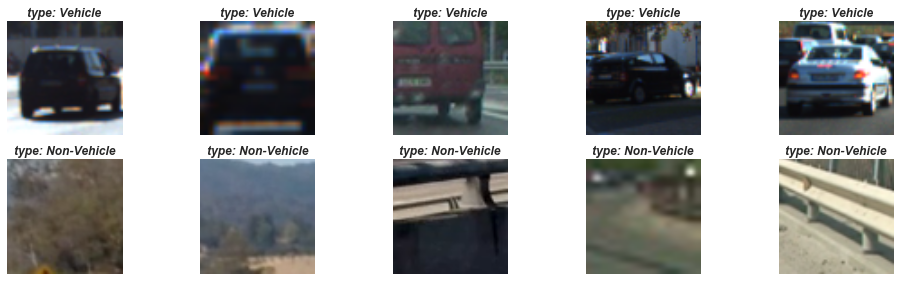

In [2]:
# 1. read in vehicles and non-vehicles, desriptive statistics
vehicle_dir    = 'data/vehicles/'
nonvehicle_dir = 'data/non-vehicles/'
vehicle_dict, vehicles = du.get_data(vehicle_dir)           
nonvehicle_dict, nonvehicles = du.get_data(nonvehicle_dir)         
# serialize to disk: TBD: change to write line by line
ds_vehicles = pd.Series(vehicles)
ds_nonvehicles = pd.Series(nonvehicles)
df = du.create_df(ds_vehicles, ds_nonvehicles)
ds_vehicles_counts = ds_vehicles.apply(lambda s: s.split('/')[2]).value_counts()
ds_nonvehicles_counts = ds_nonvehicles.apply(lambda s: s.split('/')[2]).value_counts()
ds_vehicles.to_pickle('data/vehicles.p')
ds_nonvehicles.to_pickle('data/nonvehicles.p')
print("Vehicle Image Dimensons: {}".format(mpimg.imread(ds_vehicles.ix[0]).shape))  
print("Non-Vehicle Image Dimensions: {}".format(mpimg.imread(ds_nonvehicles.ix[0]).shape))  
print("Vehicle Data Source Counts:\n{}".format(dict(ds_vehicles_counts)) )
print("Non-Vehicle Data Source Counts:\n{}".format(dict(ds_nonvehicles_counts)) )

fetch_img = lambda ds: mpimg.imread(ds[np.random.randint(0, len(ds))])
def show_image(ds, title, axi):
    axi.imshow(fetch_img(ds))
    viz.set_axi_opts(axi, **{'title': 'type: {}'.format(title)})

fig, ax = plt.subplots(2,5, figsize=(14,4))
# visualize vehicles vs nonvehicles
_ = [show_image(ds_vehicles, 'Vehicle', axi) for axi, it in zip(ax[0], range(5)) ]
_ = [show_image(ds_nonvehicles, 'Non-Vehicle', axi) for axi, it in zip(ax[1], range(5)) ]
plt.tight_layout()
fig.savefig('./output_images/vehicle_explore.png', transparent=False, bbox_inches='tight')

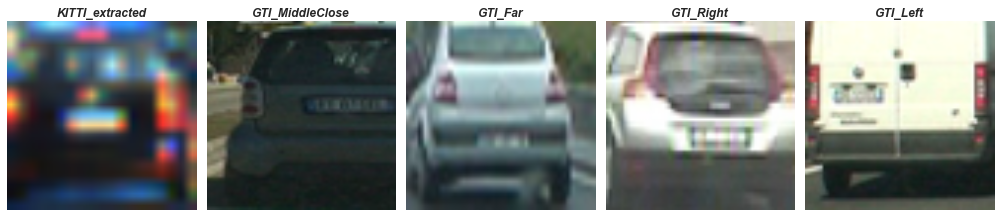

In [3]:
# visualize an example from different datasets
def show_vehicle_sources(ds):
    fig, ax = plt.subplots(1,len(ds.keys()),figsize=(14,5))
    for axi, k in zip(ax.flatten(), ds):
        r_idx = np.random.randint(0, len(ds[k]))
        fname = ds[k][r_idx]
        src = fname.split('/')[2]
        axi.imshow(mpimg.imread(fname)) 
        viz.set_axi_opts(axi, **{'title': src})
    fig.savefig('./output_images/vehicle_sources.png', transparent=False, bbox_inches='tight')
    plt.tight_layout()
    
show_vehicle_sources(vehicle_dict)

## Explore Features

### Histogram of Oriented Gradients (HOG)

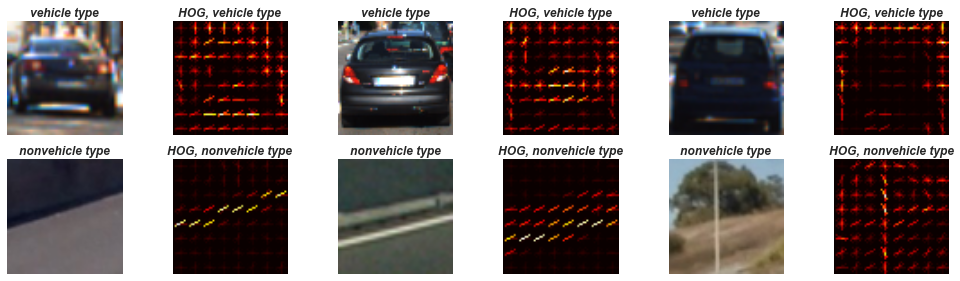

In [4]:
# define initial configuration
config = {'color_space':  'RGB',        # 'RGB' may  not be the best format
          'spatial_size': (16,16),      # Spatial binning idmensions: downsample image (64,64)->(16,16)
          'hist_bins':    16,           # Number of Histogram Bins
          'orient': 6,                  # 6-9 according to HOG literature
          'pix_per_cell': 8,            #
          'cells_per_block': 2,         # Block size to capture bigger features (helps w/normalization)
          'hog_channel': 0,             # 'ALL' or 0,1,2 ('ALL') should provide better results
          'vis': True}

fig, (ax1,ax2) = plt.subplots(2,6, figsize=(14,4))
ax1_l = ax1.flatten()
ax2_l = ax2.flatten()
[cvf.show_hog_features(ds_vehicles, ax1_l[it], ax1_l[it+1], 'vehicle', **config) for it in range(0,6,2)]
[cvf.show_hog_features(ds_nonvehicles, ax2_l[it], ax2_l[it+1], 'nonvehicle', **config) for it in range(0,6,2)]
plt.tight_layout()
fig.savefig('./output_images/hog_explore.png', transparent=False, bbox_inches='tight')

### Histograms of Color

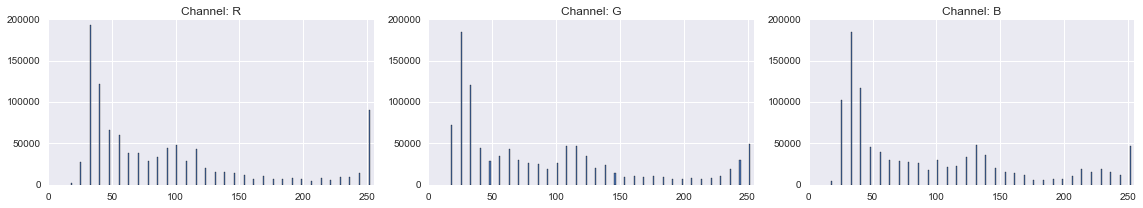

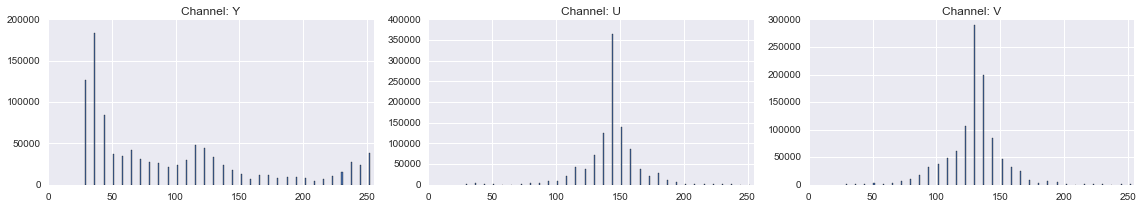

In [5]:
cvf.show_color_hist(mpimg.imread(ds_vehicles.ix[0]), color_space='RGB', nbins=32, scale=255)
cvf.show_color_hist(mpimg.imread(ds_vehicles.ix[0]), color_space='YUV', nbins=32, scale=255)
fig.savefig('./output_images/colorhist_explore.png', transparent=False, bbox_inches='tight')

### Color Space

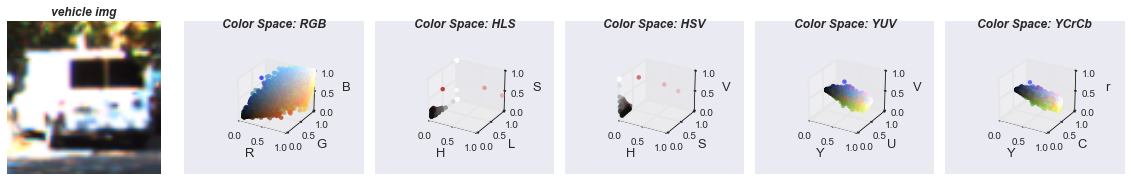

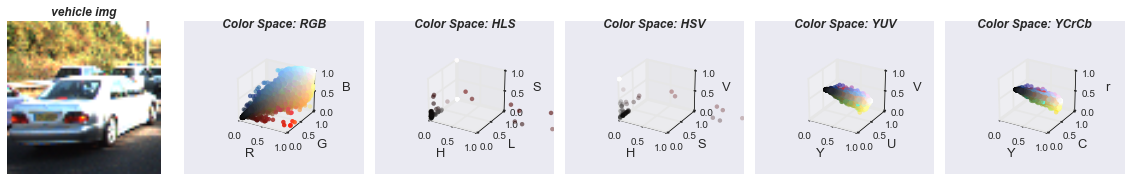

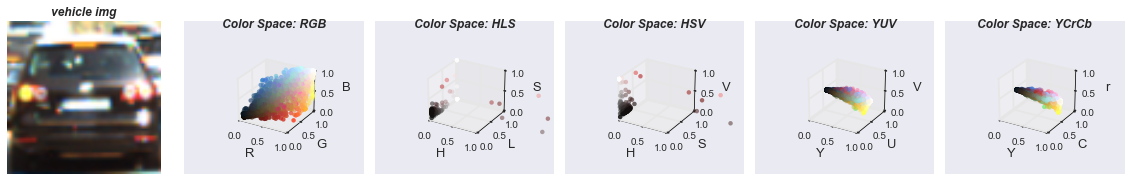

In [6]:
# Different Images across a different color space 
# Compare Vehicle vs Non-Vehicle in transformed space
def show_color3d_plots(img, ds_type, n_axis=4):
    fig = plt.figure(figsize=(16,14))
    n_axis = n_axis + 1
    ax  = ["".join([str(n_axis),str(n_axis),str(it+1)]) for it in range(n_axis)]
    # base image 
    ax1 = fig.add_subplot(ax[0])
    ax1.imshow(img)
    viz.set_axi_opts(ax1, **{'title': '{} img'.format(ds_type)})
    # 3d images 
    for axi, cspace in zip(ax[1:], ['RGB', 'HLS', 'HSV', 'YUV', 'YCrCb']):
        ax_3d = fig.add_subplot(axi, projection='3d') 
        ax_3d.dist = 18
        cvf.show_color_space(ax_3d, img, color_space=cspace)
        params = {'fontweight':'bold', 'fontstyle':'italic', 'fontsize': 12}
        ax_3d.set_title("Color Space: {}".format(cspace), **params)
    plt.subplots_adjust(top=0.2)
    plt.tight_layout()
    filename = "_".join(['colorspace', ds_type, 'explore']) + '.png'
    fig.savefig(os.path.join('output_images',filename), transparent=False, bbox_inches='tight')
    

def sample_colorspace(ds, ds_type, n_samples):
    for it in range(n_samples): 
        r_idx = np.random.randint(0, len(ds))
        show_color3d_plots(mpimg.imread(ds.ix[r_idx]), ds_type, n_axis=5)
        
sample_colorspace(ds_vehicles, ds_type='vehicle', n_samples=3)    

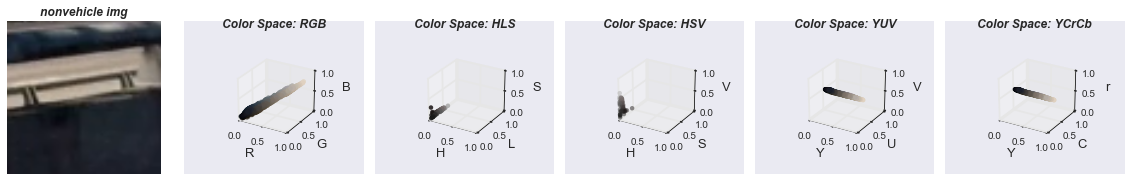

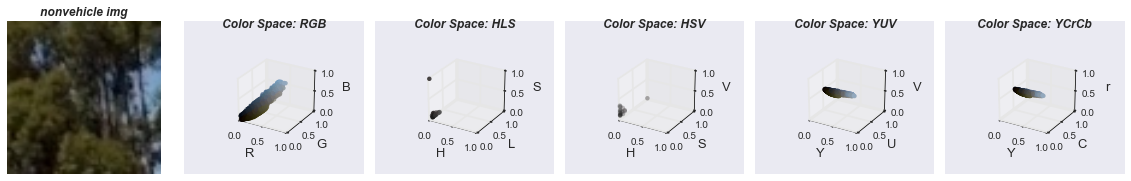

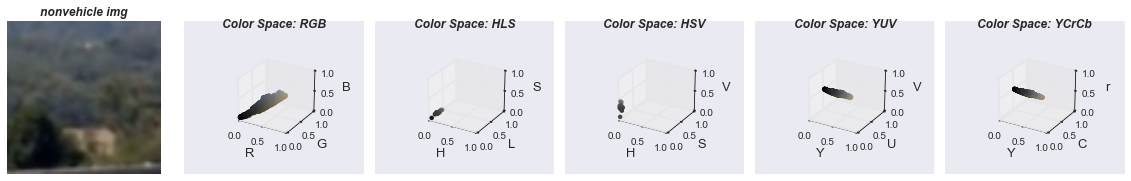

In [7]:
sample_colorspace(ds_nonvehicles, ds_type='nonvehicle', n_samples=3)   

### Spatial Binning Distribution 
- Distribution of pixels as a flattened 1D Feature Vector

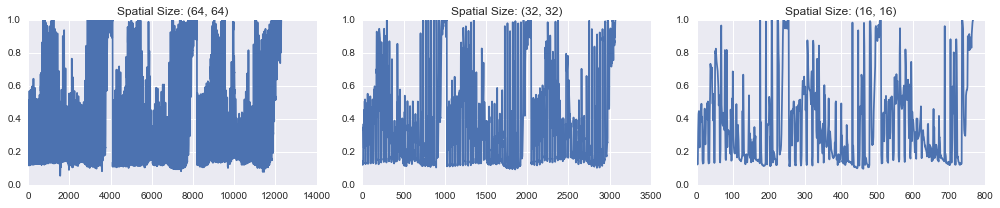

In [8]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,3))
cvf.show_spatial_bin(mpimg.imread(ds_vehicles.ix[0]), ax1, color_space='RGB', size=(64,64))
cvf.show_spatial_bin(mpimg.imread(ds_vehicles.ix[0]), ax2, color_space='RGB', size=(32,32))
cvf.show_spatial_bin(mpimg.imread(ds_vehicles.ix[0]), ax3, color_space='RGB', size=(16,16))
plt.tight_layout()
fig.savefig('./output_images/spatialbin_explore.png', transparent=False, bbox_inches='tight')

## Tune Features & Train Model
- Note that this phase takes a long time to tune, extract featues and train
- Uses K-Fold CV

In [9]:
if not os.path.exists('ckpts/tuned_params.p'):
    n_samples = int(len(ds_vehicles)*0.3)
    pl.pipeline_tune_params(LinearSVC(), ds_vehicles, ds_nonvehicles, n_samples)
with open('./ckpts/tuned_params.p', 'rb') as f:
    data_dict = pickle.load(f)
    tune_config = data_dict['params']
    tune_config_dict = data_dict['stats']
    del data_dict
# log final configurations
tune_config

Tuned Parameter: color_space, 'Param': YCrCb, 'Score': 0.9990291391389295
Tuned Parameter: pix_per_cell, 'Param': 8, 'Score': 0.9988654123577696
Tuned Parameter: cells_per_block, 'Param': 2, 'Score': 0.9983729495527667
Tuned Parameter: orient, 'Param': 7, 'Score': 0.997948910050909
Tuned Parameter: hog_channel, 'Param': ALL, 'Score': 0.9990866001466461
Tuned Parameter: spatial_size, 'Param': (16, 16), 'Score': 0.9986292929275166
Tuned Parameter: hist_bins, 'Param': 48, 'Score': 0.9990434754173411


{'cells_per_block': 2,
 'color_space': 'YCrCb',
 'hist_bins': 48,
 'hog_channel': 'ALL',
 'log': False,
 'orient': 7,
 'pix_per_cell': 8,
 'spatial_size': (16, 16),
 'vis': False}

In [7]:
# make adjustments based on exploration and false positives
tune_config_md = tune_config.copy()
tune_config_md['hist_bins'] = 32
tune_config_md['spatial_size'] = (32,32)
tune_config_md['orient'] = 9
with open('./ckpts/tuned_params.p', 'wb') as f:
    pickle.dump({'params': tune_config_md, 'stats': tune_config_dict}, f)

In [16]:
# fit the model, using svm.SVC instead of LinearSVC as we want probabillities
if not os.path.exists('ckpts/models.p'):
    X_train, y_train, X_val, y_val = \
    mdl.partition_data_basic(ds_vehicles, ds_nonvehicles, n_samples=-1, split_size=0.8, **tune_config_md)
    scaler, X_train, X_val = mdl.scale_data(X_train, X_val)
    print('Training Split Distribution: {}'.format(dict(pd.Series(y_train).value_counts())) )
    print('Validation Split Distribution: {}'.format(dict(pd.Series(y_val).value_counts())) )
    
    clf_svm = svm.SVC(kernel='linear', probability=True)
    train_params = {'log': True, 'cv': True}
    clf_svm, score = mdl.train(clf_svm, X_train, y_train, X_val, y_val, **train_params)
    with open('./ckpts/models.p', 'wb') as f: 
        pickle.dump({'model': clf_svm, 'scaler': scaler}, f)
    with open('./ckpts/data_partition.p', 'wb') as f: 
        pickle.dump({'train': (X_train, y_train), 'validation': (X_val, y_val)}, f)  

Training Split Distribution: {0.0: 7199, 1.0: 7009}
Validation Split Distribution: {0.0: 1769, 1.0: 1783}
Training Time: 868.12
Training Accuracy of clf: SVC: 0.9997534233213047
Test Accuracy of clf: SVC, 0.9990531607012809


In [10]:
# extract serialed model from disk
with open('./ckpts/models.p', 'rb') as f:
    data_dict = pickle.load(f)
    clf  = data_dict['model']
    clf_scaler = data_dict['scaler']
    del data_dict    
# extract training and validation from disk 
with open('./ckpts/data_partition.p', 'rb') as f:
    data_dict = pickle.load(f)
    X_train, y_train  = data_dict['train']
    X_val, y_val = data_dict['validation']
    del data_dict    

## Detections 

In [23]:
# define search configuration
search_config = tune_config_md.copy()
search_params = {
    'ys': [400,656],
    'xs': [200, None],
    'cells_per_step': 2,
    'scale': 1.5,
    'window': 64
}
search_config.update(search_params)
search_config

{'cells_per_block': 2,
 'cells_per_step': 2,
 'color_space': 'YCrCb',
 'hist_bins': 32,
 'hog_channel': 'ALL',
 'log': False,
 'orient': 9,
 'pix_per_cell': 8,
 'scale': 1.5,
 'spatial_size': (32, 32),
 'vis': False,
 'window': 64,
 'xs': [200, None],
 'ys': [400, 656]}

In [24]:
def find_coords(base_img, **config):
    """
    Get the coordinates for the original bounding boxes and heatmaps
    """
    finder.update_config(**config)
    tr_img, nsteps, hog_features = finder.config_hog_search(base_img)
    bbox_coords, heatmap_coords  = finder.subsample_hog_features(tr_img, clf, nsteps, hog_features)    
    return bbox_coords, heatmap_coords


def pipeline_process_frame(base_img, scales, **kwargs):
    """
    axi: (ax1,ax2) axis is used for visualization of images
    """
    bbox_coords_l = []
    heatmap_coords_l = []
    for scale in scales:
        bbox_config = search_config.copy()
        bbox_config['scale'] = scale
        bbox_coords, heatmap_coords = find_coords(base_img, **bbox_config)
        for it in bbox_coords: bbox_coords_l.append(it)
        for it in heatmap_coords: heatmap_coords_l.append(it)
    # before optimization        
    bbox_img = viz.draw_bboxes(base_img, bbox_coords_l)    
    # minimize windows per heatmap
    draw_img, heat_thresh, labels = tracker.process_frame(base_img, heatmap_coords_l)
    # remove any negative values
    heat_thresh = np.clip(heat_thresh, 0, 255)
    # plot images
    if 'axi' in kwargs and kwargs['axi']:
        ax1, ax2, ax3 = kwargs['axi']
        ax1.imshow(bbox_img)
        viz.set_axi_opts(ax1, **{'title': 'image: {}'.format(kwargs['name'])})        
        ax2.imshow(draw_img)
        viz.set_axi_opts(ax2, **{'title': 'image: {}'.format(kwargs['name'])})
        ax3.imshow(heat_thresh, cmap='hot')
        viz.set_axi_opts(ax3, **{'title': 'heatmap thresh instances: {}'.format(labels[1])})
    return draw_img

test_fnames = glob.glob('test_images/*')    
shape_dim = mpimg.imread(test_fnames[0]).shape
finder  = sch.Search(clf_scaler, **search_config)
tracker = f2f.F2FTracker(shape_dim[:2], window_size=1)
scales=[1.0, 1.25, 1.50, 2.0]

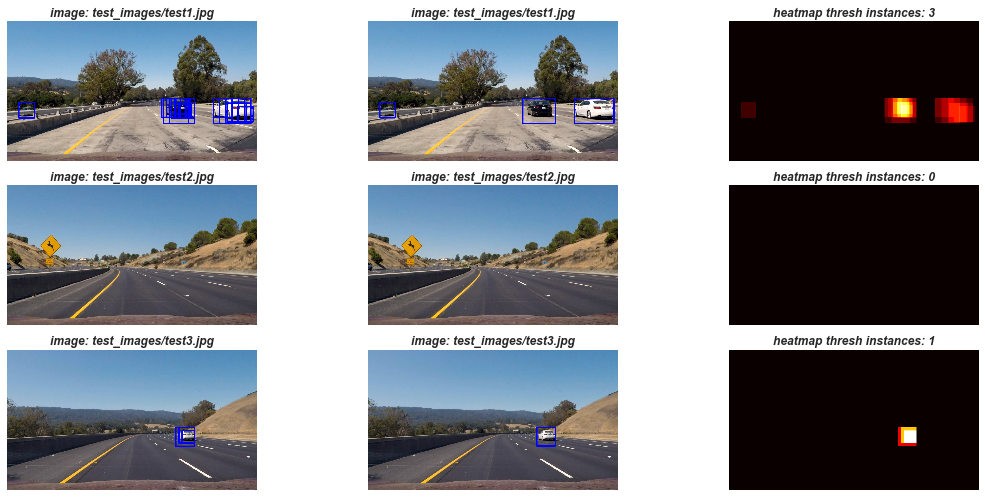

In [25]:
fig, ax = plt.subplots(3,3, figsize=(16,7))
ax = ax.flatten()
ax = [(ax[it],ax[it+1],ax[it+2]) for it in range(0,len(ax),3) ]
[pipeline_process_frame(mpimg.imread(fname), scales, **{'axi':axi, 'name': fname}) 
 for axi, fname in zip(ax,test_fnames[:3]) ]
plt.tight_layout()
fig.savefig('./output_images/heatmap_explore_1.png', transparent=False, bbox_inches='tight')

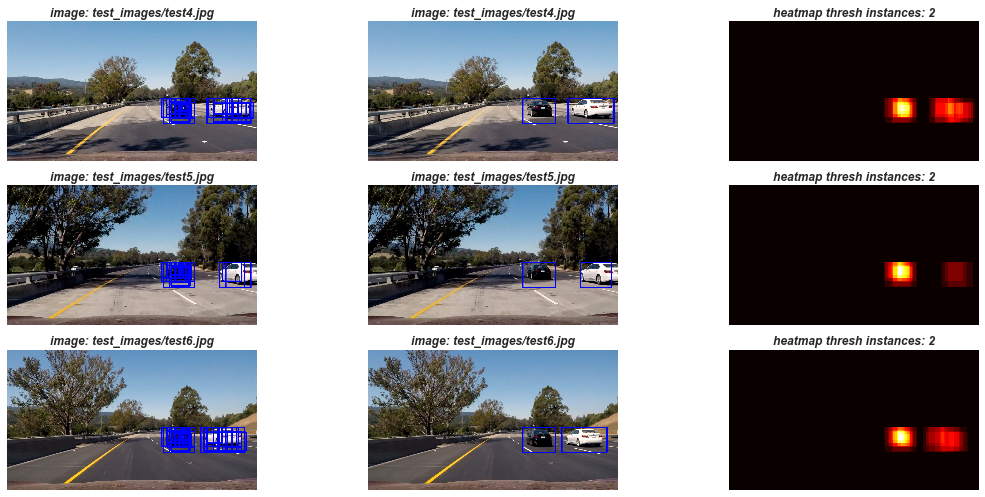

In [26]:
fig, ax = plt.subplots(3,3, figsize=(16,7))
ax = ax.flatten()
ax = [(ax[it],ax[it+1],ax[it+2]) for it in range(0,len(ax),3) ]
[pipeline_process_frame(mpimg.imread(fname), scales, **{'axi':axi, 'name': fname}) 
 for axi, fname in zip(ax,test_fnames[3:]) ]
plt.tight_layout()
fig.savefig('./output_images/heatmap_explore_2.png', transparent=False, bbox_inches='tight')